In [1]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from scipy.linalg import sqrtm
import numpy as np
from math import sqrt
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision.datasets import MNIST, CIFAR10
import sys
from tqdm import tqdm
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import copy
import gc
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Identity()
resnet18.to(device).eval()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
labels = np.load('../CIFAR-10-C/labels.npy')
selected_indices_0 = labels == 0
selected_indices_1 = labels == 1

def data_preprocess(images):
    images_0 = torch.stack([preprocess(image) for image in images[selected_indices_0]]).to(device)
    images_1 = torch.stack([preprocess(image) for image in images[selected_indices_1]]).to(device)
    with torch.no_grad():
        embedding_0 = resnet18(images_0)
        embedding_1 = resnet18(images_1)
        embedding_0 = torch.concatenate([embedding_0, torch.ones(embedding_0.size()[0],1).to(device)], dim=1)
        embedding_1 = torch.concatenate([embedding_1, torch.ones(embedding_1.size()[0],1).to(device)], dim=1)
        # print(embedding_0.size(), embedding_1.size())
    return embedding_0, embedding_1


images = np.load('../CIFAR-10-C/brightness.npy')
images_a_0_embedding, images_a_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/contrast.npy')
images_b_0_embedding, images_b_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/defocus_blur.npy')
images_c_0_embedding, images_c_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/elastic_transform.npy')
images_d_0_embedding, images_d_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/fog.npy')
images_e_0_embedding, images_e_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/frost.npy')
images_f_0_embedding, images_f_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/gaussian_blur.npy')
images_g_0_embedding, images_g_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/gaussian_noise.npy')
images_h_0_embedding, images_h_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/glass_blur.npy')
images_i_0_embedding, images_i_1_embedding = data_preprocess(images)
images = np.load('../CIFAR-10-C/impulse_noise.npy')
images_j_0_embedding, images_j_1_embedding = data_preprocess(images)
P_x = torch.concatenate([
    images_a_0_embedding[4000:],
    images_b_0_embedding[4000:],
    images_c_0_embedding[4000:],
    images_d_0_embedding[4000:],
    images_e_0_embedding[4000:],
    images_f_0_embedding[4000:],
    images_g_0_embedding[4000:],
    images_h_0_embedding[4000:],
    images_i_0_embedding[4000:],
    images_j_0_embedding[4000:],
    images_a_1_embedding[4000:],
    images_b_1_embedding[4000:],
    images_c_1_embedding[4000:],
    images_d_1_embedding[4000:],
    images_e_1_embedding[4000:],
    images_f_1_embedding[4000:],
    images_g_1_embedding[4000:],
    images_h_1_embedding[4000:],
    images_i_1_embedding[4000:],
    images_j_1_embedding[4000:]
])
P_y = torch.concatenate([torch.zeros(10000), torch.ones(10000)]).to(device)
del resnet18
allocated_memory = torch.cuda.memory_allocated()
print(f"Already allocated: {allocated_memory / 1024 ** 2} MB")
print(P_x.size(), P_y.size())

Already allocated: 234.9189453125 MB
torch.Size([20000, 513]) torch.Size([20000])


In [4]:
# image0 = np.load("/gfshome/cifar5m-part0.npz")
# image1 = np.load("/gfshome/cifar5m-part1.npz")
# X_tensor = torch.concatenate([torch.tensor(image0['X'], device = device).permute(0, 3, 1, 2), torch.tensor(image1['X'], device = device).permute(0, 3, 1, 2)], dim=0)
# Y_tensor = torch.concatenate([torch.tensor(image0['Y'], device = device), torch.tensor(image1['Y'], device = device)], dim=0)
# X_tensor = torch.tensor(image1['X'], device = device).permute(0, 3, 1, 2)
# Y_tensor = image1['Y']
# mask_0 = (Y_tensor == 0)
# mask_1 = (Y_tensor == 1)
# X_train_tensor_0 = X_tensor[mask_0][:100000,:,:,:]/256
# X_train_tensor_1 = X_tensor[mask_1][:100000,:,:,:]/256
# X_test_tensor_0 = X_tensor[mask_0][100000:150000,:,:,:]/256
# X_test_tensor_1 = X_tensor[mask_1][:50000,:,:,:]/256
# X_train_tensor_0 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_train_tensor_0)
# X_train_tensor_1 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_train_tensor_1)
# X_test_tensor_0 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_test_tensor_0)
# X_test_tensor_1 = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_test_tensor_1)

In [5]:
D = 4
T = 4
test_size_L, test_size_H, test_size_step = 30, 50, 10
test_size_num = [30, 300, 3000]
# train_size = 800
train_size_num = [300, 400, 500]
# candidate_L, candidate_H, candidate_step = 200, 600, 200
candidate_num = 400
top_candidate = [1, 5, 9]
penalty = 10
eps = 0.01
width = 0.15
gap = 0.05
MCsample = 500
sigma = 1e-1

In [6]:
# with torch.no_grad():
#     X_train_0_embedding = resnet18(X_train_tensor_0)
#     X_train_1_embedding = resnet18(X_train_tensor_1)
#     X_test_0_embedding = resnet18(X_test_tensor_0)
    # X_test_1_embedding = resnet18(X_test_tensor_1)
#     torch.save(X_train_0_embedding, "/gfshome/train_0.pt")
#     torch.save(X_train_1_embedding, "/gfshome/train_1.pt")
#     torch.save(X_test_0_embedding, "/gfshome/test_0.pt")
    # torch.save(X_test_1_embedding, "/gfshome/test_1.pt")

In [7]:
# X_train_0_embedding = torch.load("/gfshome/train_0.pt")
# X_train_1_embedding = torch.load("/gfshome/train_1.pt")
# X_train_0_embedding = torch.concatenate([X_train_0_embedding, torch.ones(X_train_0_embedding.size()[0],1).to(device)], dim=1)
# X_train_1_embedding = torch.concatenate([X_train_1_embedding, torch.ones(X_train_1_embedding.size()[0],1).to(device)], dim=1)
# X_test_0_embedding = torch.load("/gfshome/test_0.pt")
# X_test_1_embedding = torch.load("/gfshome/test_1.pt")
# P_x = torch.concatenate([X_test_0_embedding[:p], X_test_1_embedding[:p]])
# P_x = torch.concatenate([P_x, torch.ones(P_x.size()[0],1).to(device)], dim=1)
# P_y = torch.concatenate([torch.zeros(p), torch.ones(p)]).to(device)
# # allocated_memory = torch.cuda.memory_allocated()
# # print(f"Already allocated: {allocated_memory / 1024 ** 2} MB")
# # print(X_test_0_embedding.size())
# input_dim = P_x.size()[1]

In [8]:
# X_train_embedding = torch.load("/gfshome/IMDB_train_embeddeings.pt")
# X_train_embedding = X_train_embedding.detach().to(torch.float).to(device)
# X_train_0_embedding = torch.concatenate([X_train_embedding[:12500,:], torch.ones(12500,1).to(device)], dim=1)
# X_train_1_embedding = torch.concatenate([X_train_embedding[12500:,:], torch.ones(12500,1).to(device)], dim=1)
# P_x = torch.load("/gfshome/IMDB_train_embeddeings.pt")
# P_x = P_x.detach().to(torch.float).to(device)
# P_x = torch.concatenate([P_x, torch.ones(P_x.size()[0],1).to(device)], dim=1)
# P_y = torch.concatenate([torch.zeros(12500), torch.ones(12500)]).to(device)
# # P_y = torch.load("/gfshome/IMDB_train_labels.pt")

In [9]:
class dataset:
    def __init__(self, X, y, score, post_loss, base_loss, smooth, post_acc, base_acc, noise_ratio, label_mae, bias_mae):
        self.X = X
        self.y = y
        self.score = score
        self.post_loss = post_loss
        self.base_loss = base_loss
        self.smooth = smooth
        self.post_acc = post_acc
        self.base_acc = base_acc
        self.noise_ratio = noise_ratio
        self.label_mae = label_mae
        self.bias_mae = bias_mae

class result:
    def __init__(self, score_loss, score_acc, post_loss_loss, post_loss_acc, base_loss_loss, base_loss_acc, smooth_loss, smooth_acc, post_acc_loss, post_acc_acc, base_acc_loss, base_acc_acc):
        self.score_loss = score_loss
        self.score_acc = score_acc
        self.post_loss_loss = post_loss_loss
        self.post_loss_acc = post_loss_acc
        self.base_loss_loss = base_loss_loss
        self.base_loss_acc = base_loss_acc
        self.smooth_loss = smooth_loss
        self.smooth_acc = smooth_acc
        self.post_acc_loss = post_acc_loss
        self.post_acc_acc = post_acc_acc
        self.base_acc_loss = base_acc_loss
        self.base_acc_acc = base_acc_acc

    def add(self, another):        
        self.score_loss += another.score_loss
        self.score_acc += another.score_acc
        self.post_loss_loss += another.post_loss_loss
        self.post_loss_acc += another.post_loss_acc
        self.base_loss_loss += another.base_loss_loss
        self.base_loss_acc += another.base_loss_acc
        self.smooth_loss += another.smooth_loss
        self.smooth_acc += another.smooth_acc
        self.post_acc_loss += another.post_acc_loss
        self.post_acc_acc += another.post_acc_acc
        self.base_acc_loss += another.base_acc_loss
        self.base_acc_acc += another.base_acc_acc

    def divide(self, num):        
        self.score_loss = self.score_loss / num
        self.score_acc = self.score_acc / num
        self.post_loss_loss = self.post_loss_loss / num
        self.post_loss_acc = self.post_loss_acc / num
        self.base_loss_loss = self.base_loss_loss / num
        self.base_loss_acc = self.base_loss_acc / num
        self.smooth_loss = self.smooth_loss / num
        self.smooth_acc = self.smooth_acc / num
        self.post_acc_loss = self.post_acc_loss / num
        self.post_acc_acc = self.post_acc_acc / num
        self.base_acc_loss = self.base_acc_loss / num
        self.base_acc_acc = self.base_acc_acc / num

    def getacc(self):
        return [self.score_acc, self.post_loss_acc, self.base_loss_acc, self.smooth_acc, self.post_acc_acc, self.base_acc_acc]
    
    def getloss(self):
        return [self.score_loss, self.post_loss_loss, self.base_loss_loss, self.smooth_loss, self.post_acc_loss, self.base_acc_loss]

#    def self_print(self, num):
#        print("score: ", self.score_loss/num, self.score_acc/num, "\nlog loss:", self.err_loss/num, self.err_acc/num, "\naccuracy:", self.acc_loss/num, self.acc_acc/num)


class summary:
    def __init__(self, percentage_smooth_post, percentage_score_post, percentage_post_base_loss, percentage_post_base_acc, total_result):
        self.percentage_smooth_post = percentage_smooth_post
        self.percentage_score_post = percentage_score_post
        self.percentage_post_base_loss = percentage_post_base_loss
        self.percentage_post_base_acc = percentage_post_base_acc
        self.total_result = total_result
        
    def add(self, another):
        self.percentage_smooth_post = np.add(self.percentage_smooth_post, another.percentage_smooth_post)
        self.percentage_score_post = np.add(self.percentage_score_post, another.percentage_score_post)
        self.percentage_post_base_loss = np.add(self.percentage_post_base_loss, another.percentage_post_base_loss)
        self.percentage_post_base_acc = np.add(self.percentage_post_base_acc, another.percentage_post_base_acc)
        self.total_result.add(another.total_result)
        
    def divide(self, num):
        self.percentage_smooth_post = self.percentage_smooth_post / num
        self.percentage_score_post = self.percentage_score_post / num 
        self.percentage_post_base_loss = self.percentage_post_base_loss / num 
        self.percentage_post_base_acc = self.percentage_post_base_acc / num
        self.total_result.divide(num)

    def getacc(self):
        return self.total_result.getacc()
    
    def getloss(self):
        return self.total_result.getloss()

#    def self_print_percentage(self, num):
#        print(self.percentage_loss_err/num, self.percentage_loss_acc/num, self.percentage_acc_err/num, self.percentage_acc_acc/num)

#    def self_print_result(self, num):
#        self.total_result.self_print(num)

In [10]:
def sigmoid(z):
    return 1/(1 + torch.exp(-z))

# def generate_data_cifar10(num, dataset, label):
#     indices = torch.randperm(dataset.size(0))[:num]
#     X = dataset[indices]
#     y = torch.ones(num) * label
#     y = torch.tensor(y, dtype=torch.int)
#     y = y.to(device)
#     return X, y

def generate_data_cifar10(indices, dataset, label):
    X = dataset[indices]
    y = torch.ones(X.size()[0]) * label
    y = torch.tensor(y, dtype=torch.int)
    y = y.to(device)
    return X, y, X.size()[0]

# def generate_dataset_cifar10(N, noise):
#     N_0 = random.randint(1,N-1)
#     X0, y0 = generate_data_cifar10(N_0, X_train_0_embedding, 0)
#     X1, y1 = generate_data_cifar10(N-N_0, X_train_1_embedding, 1)

#     X = torch.concatenate((X0, X1), axis = 0)
#     y = torch.concatenate((y0, y1), axis = 0)
#     for i in range(N):
#         flip = torch.bernoulli(torch.tensor(noise)).item()
#         if flip == 1:
#             y[i] = 1 - y[i]
#     return np.abs(N_0/N-0.5), X, y

def generate_dataset_cifar10(N, noise):
    perm_indices = torch.randperm(80000).to(device)
    sample_indices = perm_indices[:N]
    sample_mean = 1/10
    a_0 = sample_indices[(sample_indices >= 0) & (sample_indices < 4000)]
    b_0 = sample_indices[(sample_indices >= 4000) & (sample_indices < 8000)] - 4000
    c_0 = sample_indices[(sample_indices >= 8000) & (sample_indices < 12000)] - 8000
    d_0 = sample_indices[(sample_indices >= 12000) & (sample_indices < 16000)] - 12000
    e_0 = sample_indices[(sample_indices >= 16000) & (sample_indices < 20000)] - 16000
    f_0 = sample_indices[(sample_indices >= 20000) & (sample_indices < 24000)] - 20000
    g_0 = sample_indices[(sample_indices >= 24000) & (sample_indices < 28000)] - 24000
    h_0 = sample_indices[(sample_indices >= 28000) & (sample_indices < 32000)] - 28000
    i_0 = sample_indices[(sample_indices >= 32000) & (sample_indices < 36000)] - 32000
    j_0 = sample_indices[(sample_indices >= 36000) & (sample_indices < 40000)] - 36000
    a_1 = sample_indices[(sample_indices >= 40000) & (sample_indices < 44000)] - 40000
    b_1 = sample_indices[(sample_indices >= 44000) & (sample_indices < 48000)] - 44000
    c_1 = sample_indices[(sample_indices >= 48000) & (sample_indices < 52000)] - 48000
    d_1 = sample_indices[(sample_indices >= 52000) & (sample_indices < 56000)] - 52000
    e_1 = sample_indices[(sample_indices >= 56000) & (sample_indices < 60000)] - 56000
    f_1 = sample_indices[(sample_indices >= 60000) & (sample_indices < 64000)] - 60000
    g_1 = sample_indices[(sample_indices >= 64000) & (sample_indices < 68000)] - 64000
    h_1 = sample_indices[(sample_indices >= 68000) & (sample_indices < 72000)] - 68000
    i_1 = sample_indices[(sample_indices >= 72000) & (sample_indices < 76000)] - 72000
    j_1 = sample_indices[(sample_indices >= 76000) & (sample_indices < 80000)] - 76000
    label_0 = ((sample_indices >= 0) & (sample_indices < 40000)).sum()
    label_mae = torch.abs(label_0/N-0.5).item()
    a_X_0, a_y_0, a_num_0 = generate_data_cifar10(a_0, images_a_0_embedding[:4000], 0)
    a_X_1, a_y_1, a_num_1 = generate_data_cifar10(a_1, images_a_1_embedding[:4000], 1)
    b_X_0, b_y_0, b_num_0 = generate_data_cifar10(b_0, images_b_0_embedding[:4000], 0)
    b_X_1, b_y_1, b_num_1 = generate_data_cifar10(b_1, images_b_1_embedding[:4000], 1)
    c_X_0, c_y_0, c_num_0 = generate_data_cifar10(c_0, images_c_0_embedding[:4000], 0)
    c_X_1, c_y_1, c_num_1 = generate_data_cifar10(c_1, images_c_1_embedding[:4000], 1)
    d_X_0, d_y_0, d_num_0 = generate_data_cifar10(d_0, images_d_0_embedding[:4000], 0)
    d_X_1, d_y_1, d_num_1 = generate_data_cifar10(d_1, images_d_1_embedding[:4000], 1)
    e_X_0, e_y_0, e_num_0 = generate_data_cifar10(e_0, images_e_0_embedding[:4000], 0)
    e_X_1, e_y_1, e_num_1 = generate_data_cifar10(e_1, images_e_1_embedding[:4000], 1)
    f_X_0, f_y_0, f_num_0 = generate_data_cifar10(f_0, images_f_0_embedding[:4000], 0)
    f_X_1, f_y_1, f_num_1 = generate_data_cifar10(f_1, images_f_1_embedding[:4000], 1)
    g_X_0, g_y_0, g_num_0 = generate_data_cifar10(g_0, images_g_0_embedding[:4000], 0)
    g_X_1, g_y_1, g_num_1 = generate_data_cifar10(g_1, images_g_1_embedding[:4000], 1)
    h_X_0, h_y_0, h_num_0 = generate_data_cifar10(h_0, images_h_0_embedding[:4000], 0)
    h_X_1, h_y_1, h_num_1 = generate_data_cifar10(h_1, images_h_1_embedding[:4000], 1)
    i_X_0, i_y_0, i_num_0 = generate_data_cifar10(i_0, images_i_0_embedding[:4000], 0)
    i_X_1, i_y_1, i_num_1 = generate_data_cifar10(i_1, images_i_1_embedding[:4000], 1)
    j_X_0, j_y_0, j_num_0 = generate_data_cifar10(j_0, images_j_0_embedding[:4000], 0)
    j_X_1, j_y_1, j_num_1 = generate_data_cifar10(j_1, images_j_1_embedding[:4000], 1)
    X = torch.concatenate([
        a_X_0,
        b_X_0,
        c_X_0,
        d_X_0,
        e_X_0,
        f_X_0,
        g_X_0,
        h_X_0,
        i_X_0,
        j_X_0,
        a_X_1,
        b_X_1,
        c_X_1,
        d_X_1,
        e_X_1,
        f_X_1,
        g_X_1,
        h_X_1,
        i_X_1,
        j_X_1
    ], axis = 0)
    y = torch.concatenate([
        a_y_0,
        b_y_0,
        c_y_0,
        d_y_0,
        e_y_0,
        f_y_0,
        g_y_0,
        h_y_0,
        i_y_0,
        j_y_0,
        a_y_1,
        b_y_1,
        c_y_1,
        d_y_1,
        e_y_1,
        f_y_1,
        g_y_1,
        h_y_1,
        i_y_1,
        j_y_1
    ], axis = 0)
    for i in range(N):
        flip = torch.bernoulli(torch.tensor(noise)).item()
        if flip == 1:
            y[i] = 1 - y[i]
    bias_mae = (
        np.abs(a_num_0/N+a_num_1/N-sample_mean)+
        np.abs(b_num_0/N+b_num_1/N-sample_mean)+
        np.abs(c_num_0/N+c_num_1/N-sample_mean)+
        np.abs(d_num_0/N+d_num_1/N-sample_mean)+
        np.abs(e_num_0/N+e_num_1/N-sample_mean)+
        np.abs(f_num_0/N+f_num_1/N-sample_mean)+
        np.abs(g_num_0/N+g_num_1/N-sample_mean)+
        np.abs(h_num_0/N+h_num_1/N-sample_mean)+
        np.abs(i_num_0/N+i_num_1/N-sample_mean)+
        np.abs(j_num_0/N+j_num_1/N-sample_mean)
    )
    return label_mae, bias_mae/10, X, y


def generate_train_cifar10(train_size, train_number):
    train_dataset = []
    for i in range(train_number):
        noise_level = random.randint(1, 30)
        # noise_level = 0
        not_found = True
        while not_found:
            label_mae, bias_mae, train_X, train_y = generate_dataset_cifar10(train_size, eps * noise_level)
            if torch.sum(train_y)>0 and torch.sum(train_y)<train_size:
                not_found = False
        train_dataset.append(dataset(train_X, train_y, 0, 0, 0, 0, 0, 0, noise_level*eps, label_mae, bias_mae))
    return train_dataset

def subsample(X, y, size):
    perm = torch.randperm(len(y))
    sample_X = X[perm[:size]]
    sample_y = y[perm[:size]]
    return sample_X, sample_y

def compute_hessian(mu, X):
    sigm = sigmoid(X @ mu.t())
    diag_sigm = (sigm * (1 - sigm)).flatten()
    res = torch.eye(X.size(1), device=device)
    res += (X.t() * diag_sigm) @ X
    return res

def compute_score(mu0, Q0, lg0, mu1, Q1, lg1, mu2, Q2, lg2):
    Q = Q1 + Q2 - Q0
    Q_t_L = torch.linalg.cholesky(Q)
    Q_t_L_inv = torch.linalg.solve_triangular(Q_t_L, torch.eye(Q_t_L.size(0), device=device), upper=False)
    Q_inv = Q_t_L_inv.T @ Q_t_L_inv
    mu = torch.matmul(Q_inv, torch.matmul(Q1, mu1) + torch.matmul(Q2, mu2) - torch.matmul(Q0, mu0))

    lg12 = 2 * torch.sum(torch.log(torch.diagonal(Q_t_L)))

    lg = lg1+lg2-lg12-lg0

    sqr = torch.matmul(mu.T, torch.matmul(Q, mu)) - torch.matmul(mu1.T, torch.matmul(Q1, mu1)) - torch.matmul(mu2.T, torch.matmul(Q2, mu2)) + torch.matmul(mu0.T, torch.matmul(Q0, mu0))

    score = 0.5 * (lg + sqr)

    return score.item()

def compute_data_score_err(mu_test, Q_test, test_X, test_y, train_X, train_y, lg2):
    test_N = test_y.size()[0]
    M = test_X.size()[1]

    mu0 = torch.zeros((1, M))
    mu0 = mu0.to(device)
    Q0 = torch.eye(M)/penalty
    Q0 = Q0.to(device)
    # lg0 = -M * torch.log(torch.tensor(penalty/2))
    lg0 = 0
    
    train = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(train_X.cpu(), train_y.cpu())
    mu_train = torch.tensor(train.coef_, dtype=torch.float32, device=device)
    # mu_train_numpy = mu_train.detach().squeeze().cpu().numpy()

    Q_train = compute_hessian(mu_train, train_X)
    Q_train_L = torch.linalg.cholesky(Q_train)
    Q_train_L_inv = torch.linalg.solve_triangular(Q_train_L, torch.eye(Q_train_L.size(0), device=device), upper=False)
    # Q_train_inverse = Q_train_L_inv.T @ Q_train_L_inv
    # Q_train_inverse = torch.inverse(Q_train)
    # Q_numpy = Q_train_inverse.detach().cpu().numpy()

    lg1 = 2 * torch.sum(torch.log(torch.diagonal(Q_train_L)))

    score = compute_score(mu0.t(), Q0, lg0, mu_train.t(), Q_train, lg1, mu_test.t(), Q_test, lg2)

    test_y = test_y.float()
    criterion = nn.BCELoss()

    base_predictive = sigmoid(torch.matmul(test_X, mu_train.t())).squeeze()
    base_predictions = (base_predictive >= 0.5).float()
    base_loss = criterion(base_predictive, test_y)
    base_acc = (base_predictions == test_y).float().mean()

    # theta_samples = np.random.multivariate_normal(mu_train_numpy, Q_numpy, MCsample, 'warn')
    z = torch.randn(MCsample, mu_train.squeeze(0).shape[0]).to(device)
    theta_samples = mu_train + z @ Q_train_L_inv.T
    post_predictive = torch.mean(sigmoid(torch.matmul(test_X, theta_samples.t())), dim=1)
    post_predictions = (post_predictive >= 0.5).float()
    post_loss = criterion(post_predictive, test_y)
    post_acc = (post_predictions == test_y).float().mean()

    theta_samples_smooth = mu_train + sqrt(sigma) * z
    smooth_predictive = torch.mean(sigmoid(torch.matmul(test_X, theta_samples_smooth.t())), dim=1)
    # smooth_predictions = (smooth_predictive >= 0.5).float()
    smooth_loss = criterion(smooth_predictive, test_y)
    # smooth_acc = (smooth_predictions == test_y).float().mean()
    
    return score, base_loss.item(), base_acc, post_loss.item(), post_acc, smooth_loss.item()

def get_err_score(train_data, test_X, test_y, train_number):
    test = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(test_X.cpu(), test_y.cpu())
    mu_test = torch.tensor(test.coef_, dtype=torch.float32, device=device)
    Q_test = compute_hessian(mu_test, test_X)

    L = torch.linalg.cholesky(Q_test)
    lg2 = 2 * torch.sum(torch.log(torch.diagonal(L)))

    for i in range(train_number):
        train_data[i].score, train_data[i].base_loss, train_data[i].base_acc, train_data[i].post_loss, train_data[i].post_acc, train_data[i].smooth = compute_data_score_err(mu_test, Q_test, test_X, test_y, train_data[i].X, train_data[i].y, lg2)

def compute_data_err_acc(test_X, test_y, train_X, train_y):
    test_N = test_y.size()[0]
    train = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(train_X.cpu(), train_y.cpu())
    mu_train = torch.tensor(train.coef_, dtype=torch.float32, device=device)
    # mu_train_numpy = mu_train.detach().squeeze().cpu().numpy()
    Q_train = compute_hessian(mu_train, train_X)
    Q_train_L = torch.linalg.cholesky(Q_train)
    Q_train_L_inv = torch.linalg.solve_triangular(Q_train_L, torch.eye(Q_train_L.size(0), device=device), upper=False)
    # Q_train_inverse = torch.inverse(Q_train)
    # Q_numpy = Q_train_inverse.detach().cpu().numpy()

    test_y = test_y.float()
    criterion = nn.BCELoss()

    base_predictive = sigmoid(torch.matmul(test_X, mu_train.t())).squeeze()
    base_predictions = (base_predictive >= 0.5).float()
    base_loss = criterion(base_predictive, test_y)
    base_acc = (base_predictions == test_y).float().mean()

    # theta_samples = np.random.multivariate_normal(mu_train_numpy, Q_numpy, MCsample, 'warn')
    # theta_samples = torch.tensor(theta_samples).to(device)
    # theta_samples = theta_samples.float()
    z = torch.randn(MCsample, mu_train.squeeze(0).shape[0]).to(device)
    theta_samples = mu_train + z @ Q_train_L_inv.T

    post_predictive = torch.mean(sigmoid(torch.matmul(test_X, theta_samples.t())), dim=1)
    post_predictions = (post_predictive >= 0.5).float()
    post_loss = criterion(post_predictive, test_y)
    post_acc = (post_predictions == test_y).float().mean()

    return base_loss.item(), base_acc, post_loss.item(), post_acc

In [11]:
def generate_plot(x_label, a_L, a_H, label1, label2, save_name):
#    print(width, gap)
    x = np.array(range(len(x_label))) * (width + gap)
#    print(e_L, e_H)
    acc_L = np.ones(len(x_label))*100 - np.array(a_H) 
    acc_H = np.ones(len(x_label))*100 - np.array(a_L)
    plt.rcParams['figure.figsize'] = [(width + gap) * (len(x_label) + 1), 4]
    plt.bar(x, acc_L, color='sandybrown', width = width, label = label1)
    plt.bar(x, np.ones(len(x_label))*100 - acc_H, bottom= acc_H, color='cornflowerblue', width = width, label = label2)
    plt.bar(x, acc_H - acc_L, bottom= acc_L, color='lightgray', width = width, label = 'Ties')
    plt.xticks(x, x_label, rotation='vertical')
    plt.tight_layout()
    plt.legend(loc=4)
    plt.savefig("figure/imdb/detail/"+save_name+".pdf", format="pdf", dpi=200) #add legend
    plt.show()

100%|██████████| 4/4 [31:32<00:00, 473.13s/it]


Acc & $1, 30, 400$ & 0.8289 & 0.8171 & 0.8120 & 0.8120 & 0.8016 & 0.8026 \\ 
Aver. Acc & $1, 30, 400$ & 0.8274 & 0.8149 & 0.8075 & 0.8112 & 0.7983 & 0.8040 \\ 
Loss & $1, 30, 400$ & 0.7101 & 0.7261 & 0.7286 & 0.7608 & 0.7597 & 0.7795 \\ 
Aver. Loss & $1, 30, 400$ & 0.4639 & 0.4815 & 0.4932 & 0.4885 & 0.5004 & 0.4980 \\ 
Noise Ratio & $1, 30, 400$ & 0.0144 & 0.0269 & 0.0344 & 0.0288 & 0.0406 & 0.0444 \\ 
Label MAE & $1, 30, 400$ & 0.0308 & 0.0188 & 0.0227 & 0.0175 & 0.0208 & 0.0246 \\  \hline
Bias MAE & $1, 30, 400$ & 0.0129 & 0.0150 & 0.0135 & 0.0135 & 0.0143 & 0.0137 \\  \hline
Acc & $5, 30, 400$ & 0.8410 & 0.8186 & 0.7879 & 0.8104 & 0.7960 & 0.7958 \\ 
Aver. Acc & $5, 30, 400$ & 0.8404 & 0.8169 & 0.7873 & 0.8093 & 0.7952 & 0.7959 \\ 
Loss & $5, 30, 400$ & 0.8071 & 0.9434 & 1.0849 & 0.9832 & 1.1026 & 1.0982 \\ 
Aver. Loss & $5, 30, 400$ & 0.4043 & 0.4382 & 0.4752 & 0.4485 & 0.4647 & 0.4661 \\ 
Noise Ratio & $5, 30, 400$ & 0.0166 & 0.0276 & 0.0474 & 0.0306 & 0.0441 & 0.0434 \\ 
Label M

100%|██████████| 4/4 [43:43<00:00, 655.83s/it]


Acc & $1, 30, 400$ & 0.8415 & 0.8020 & 0.7938 & 0.8021 & 0.7736 & 0.7999 \\ 
Aver. Acc & $1, 30, 400$ & 0.8402 & 0.7983 & 0.7918 & 0.7999 & 0.7726 & 0.7973 \\ 
Loss & $1, 30, 400$ & 0.6493 & 0.8437 & 0.8153 & 0.8306 & 0.9540 & 0.8230 \\ 
Aver. Loss & $1, 30, 400$ & 0.4543 & 0.4940 & 0.5053 & 0.4952 & 0.5225 & 0.5009 \\ 
Noise Ratio & $1, 30, 400$ & 0.0100 & 0.0413 & 0.0556 & 0.0456 & 0.0681 & 0.0469 \\ 
Label MAE & $1, 30, 400$ & 0.0177 & 0.0237 & 0.0203 & 0.0253 & 0.0247 & 0.0172 \\  \hline
Bias MAE & $1, 30, 400$ & 0.0082 & 0.0121 & 0.0113 & 0.0115 & 0.0122 & 0.0119 \\  \hline
Acc & $5, 30, 400$ & 0.8378 & 0.8074 & 0.7833 & 0.8004 & 0.7801 & 0.7791 \\ 
Aver. Acc & $5, 30, 400$ & 0.8368 & 0.8054 & 0.7821 & 0.8000 & 0.7795 & 0.7784 \\ 
Loss & $5, 30, 400$ & 0.8793 & 0.9213 & 0.8378 & 0.9201 & 0.8810 & 0.8583 \\ 
Aver. Loss & $5, 30, 400$ & 0.4031 & 0.4456 & 0.4893 & 0.4561 & 0.4928 & 0.4950 \\ 
Noise Ratio & $5, 30, 400$ & 0.0133 & 0.0331 & 0.0671 & 0.0434 & 0.0660 & 0.0701 \\ 
Label M

100%|██████████| 4/4 [56:53<00:00, 853.37s/it]


Acc & $1, 30, 400$ & 0.8376 & 0.8256 & 0.8008 & 0.8310 & 0.8178 & 0.8243 \\ 
Aver. Acc & $1, 30, 400$ & 0.8362 & 0.8240 & 0.8010 & 0.8284 & 0.8156 & 0.8237 \\ 
Loss & $1, 30, 400$ & 0.6942 & 0.7785 & 0.8316 & 0.7275 & 0.7563 & 0.7370 \\ 
Aver. Loss & $1, 30, 400$ & 0.4509 & 0.4612 & 0.4910 & 0.4598 & 0.4793 & 0.4680 \\ 
Noise Ratio & $1, 30, 400$ & 0.0100 & 0.0219 & 0.0538 & 0.0206 & 0.0319 & 0.0231 \\ 
Label MAE & $1, 30, 400$ & 0.0173 & 0.0165 & 0.0114 & 0.0159 & 0.0141 & 0.0129 \\  \hline
Bias MAE & $1, 30, 400$ & 0.0113 & 0.0112 & 0.0115 & 0.0118 & 0.0099 & 0.0108 \\  \hline
Acc & $5, 30, 400$ & 0.8391 & 0.8202 & 0.8127 & 0.8148 & 0.8131 & 0.8120 \\ 
Aver. Acc & $5, 30, 400$ & 0.8376 & 0.8188 & 0.8113 & 0.8136 & 0.8125 & 0.8105 \\ 
Loss & $5, 30, 400$ & 0.9141 & 0.8157 & 0.6533 & 0.7469 & 0.6879 & 0.7008 \\ 
Aver. Loss & $5, 30, 400$ & 0.3930 & 0.4269 & 0.4536 & 0.4417 & 0.4478 & 0.4491 \\ 
Noise Ratio & $5, 30, 400$ & 0.0125 & 0.0271 & 0.0480 & 0.0381 & 0.0439 & 0.0431 \\ 
Label M

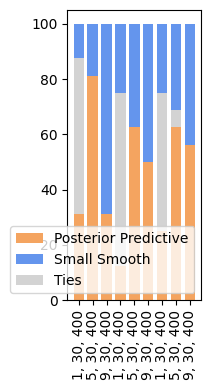

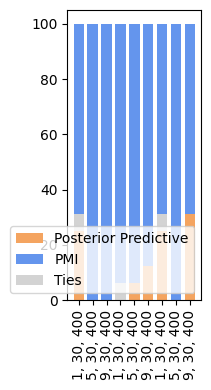

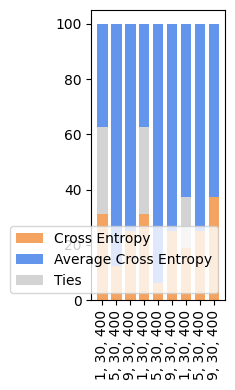

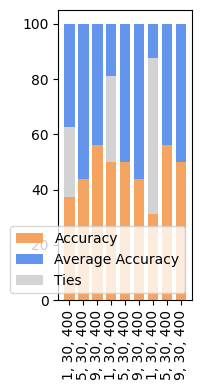

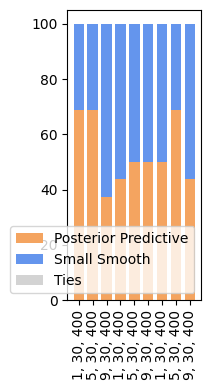

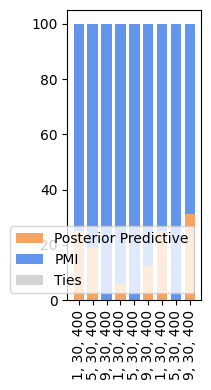

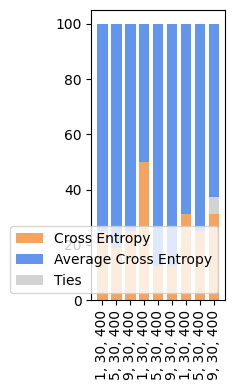

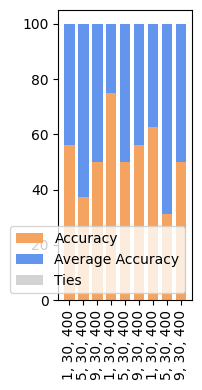

100%|██████████| 4/4 [31:12<00:00, 468.07s/it]


Acc & $1, 300, 400$ & 0.8290 & 0.8410 & 0.8307 & 0.8404 & 0.8391 & 0.8334 \\ 
Aver. Acc & $1, 300, 400$ & 0.8286 & 0.8395 & 0.8297 & 0.8389 & 0.8386 & 0.8303 \\ 
Loss & $1, 300, 400$ & 0.6462 & 0.6353 & 0.6055 & 0.5947 & 0.6258 & 0.6454 \\ 
Aver. Loss & $1, 300, 400$ & 0.4746 & 0.4585 & 0.4775 & 0.4633 & 0.4665 & 0.4743 \\ 
Noise Ratio & $1, 300, 400$ & 0.0156 & 0.0144 & 0.0231 & 0.0194 & 0.0231 & 0.0238 \\ 
Label MAE & $1, 300, 400$ & 0.0279 & 0.0348 & 0.0294 & 0.0354 & 0.0306 & 0.0215 \\  \hline
Bias MAE & $1, 300, 400$ & 0.0140 & 0.0133 & 0.0144 & 0.0151 & 0.0139 & 0.0135 \\  \hline
Acc & $5, 300, 400$ & 0.8413 & 0.8448 & 0.8282 & 0.8423 & 0.8349 & 0.8345 \\ 
Aver. Acc & $5, 300, 400$ & 0.8407 & 0.8431 & 0.8270 & 0.8419 & 0.8351 & 0.8334 \\ 
Loss & $5, 300, 400$ & 0.7755 & 0.8105 & 0.8444 & 0.7985 & 0.8370 & 0.8409 \\ 
Aver. Loss & $5, 300, 400$ & 0.4085 & 0.4023 & 0.4250 & 0.4089 & 0.4171 & 0.4189 \\ 
Noise Ratio & $5, 300, 400$ & 0.0179 & 0.0174 & 0.0276 & 0.0188 & 0.0234 & 0.0220

100%|██████████| 4/4 [41:37<00:00, 624.37s/it]


Acc & $1, 300, 400$ & 0.8382 & 0.8409 & 0.8340 & 0.8391 & 0.8360 & 0.8375 \\ 
Aver. Acc & $1, 300, 400$ & 0.8353 & 0.8401 & 0.8344 & 0.8379 & 0.8348 & 0.8356 \\ 
Loss & $1, 300, 400$ & 0.6839 & 0.6805 & 0.6474 & 0.6573 & 0.6787 & 0.6701 \\ 
Aver. Loss & $1, 300, 400$ & 0.4530 & 0.4457 & 0.4626 & 0.4521 & 0.4569 & 0.4576 \\ 
Noise Ratio & $1, 300, 400$ & 0.0131 & 0.0169 & 0.0219 & 0.0150 & 0.0156 & 0.0188 \\ 
Label MAE & $1, 300, 400$ & 0.0217 & 0.0170 & 0.0183 & 0.0198 & 0.0172 & 0.0195 \\  \hline
Bias MAE & $1, 300, 400$ & 0.0122 & 0.0120 & 0.0133 & 0.0124 & 0.0122 & 0.0122 \\  \hline
Acc & $5, 300, 400$ & 0.8407 & 0.8430 & 0.8245 & 0.8362 & 0.8355 & 0.8361 \\ 
Aver. Acc & $5, 300, 400$ & 0.8405 & 0.8428 & 0.8247 & 0.8356 & 0.8355 & 0.8359 \\ 
Loss & $5, 300, 400$ & 0.8607 & 0.8672 & 0.9356 & 0.8923 & 0.9072 & 0.9025 \\ 
Aver. Loss & $5, 300, 400$ & 0.3951 & 0.3904 & 0.4133 & 0.3966 & 0.4008 & 0.4014 \\ 
Noise Ratio & $5, 300, 400$ & 0.0153 & 0.0178 & 0.0241 & 0.0190 & 0.0193 & 0.0201

100%|██████████| 4/4 [52:35<00:00, 788.77s/it]


Acc & $1, 300, 400$ & 0.8395 & 0.8446 & 0.8371 & 0.8455 & 0.8399 & 0.8423 \\ 
Aver. Acc & $1, 300, 400$ & 0.8382 & 0.8432 & 0.8350 & 0.8427 & 0.8377 & 0.8408 \\ 
Loss & $1, 300, 400$ & 0.6818 & 0.6570 & 0.6633 & 0.6474 & 0.6700 & 0.6759 \\ 
Aver. Loss & $1, 300, 400$ & 0.4528 & 0.4356 & 0.4568 & 0.4391 & 0.4462 & 0.4458 \\ 
Noise Ratio & $1, 300, 400$ & 0.0138 & 0.0138 & 0.0169 & 0.0138 & 0.0144 & 0.0125 \\ 
Label MAE & $1, 300, 400$ & 0.0191 & 0.0239 & 0.0183 & 0.0215 & 0.0213 & 0.0184 \\  \hline
Bias MAE & $1, 300, 400$ & 0.0116 & 0.0101 & 0.0098 & 0.0108 & 0.0100 & 0.0107 \\  \hline
Acc & $5, 300, 400$ & 0.8405 & 0.8445 & 0.8324 & 0.8404 & 0.8374 & 0.8362 \\ 
Aver. Acc & $5, 300, 400$ & 0.8400 & 0.8450 & 0.8306 & 0.8401 & 0.8363 & 0.8360 \\ 
Loss & $5, 300, 400$ & 0.9022 & 0.8544 & 0.8491 & 0.8592 & 0.8579 & 0.8551 \\ 
Aver. Loss & $5, 300, 400$ & 0.3885 & 0.3799 & 0.4028 & 0.3855 & 0.3949 & 0.3929 \\ 
Noise Ratio & $5, 300, 400$ & 0.0138 & 0.0146 & 0.0181 & 0.0153 & 0.0178 & 0.0185

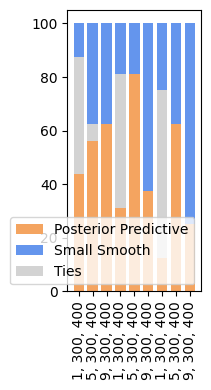

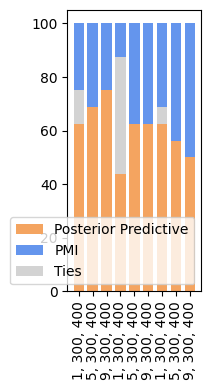

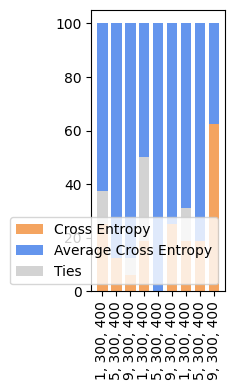

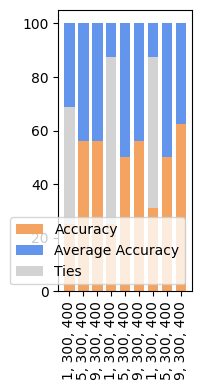

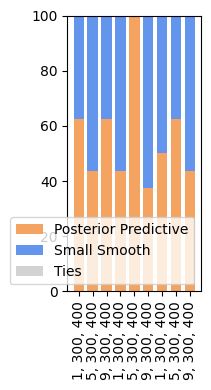

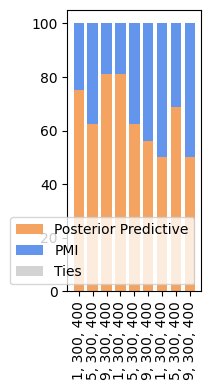

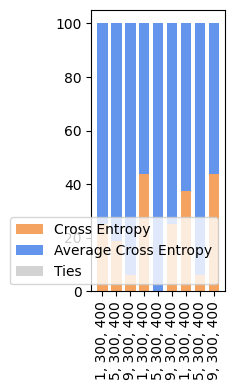

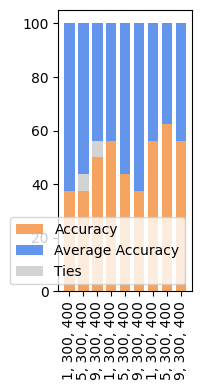

100%|██████████| 4/4 [32:23<00:00, 485.95s/it]


Acc & $1, 3000, 400$ & 0.8241 & 0.8349 & 0.8410 & 0.8426 & 0.8393 & 0.8419 \\ 
Aver. Acc & $1, 3000, 400$ & 0.8221 & 0.8342 & 0.8387 & 0.8413 & 0.8384 & 0.8391 \\ 
Loss & $1, 3000, 400$ & 0.6931 & 0.6611 & 0.5676 & 0.5891 & 0.6069 & 0.6049 \\ 
Aver. Loss & $1, 3000, 400$ & 0.4753 & 0.4520 & 0.4707 & 0.4562 & 0.4670 & 0.4636 \\ 
Noise Ratio & $1, 3000, 400$ & 0.0188 & 0.0206 & 0.0238 & 0.0225 & 0.0200 & 0.0181 \\ 
Label MAE & $1, 3000, 400$ & 0.0248 & 0.0246 & 0.0244 & 0.0229 & 0.0363 & 0.0296 \\  \hline
Bias MAE & $1, 3000, 400$ & 0.0134 & 0.0135 & 0.0151 & 0.0177 & 0.0144 & 0.0147 \\  \hline
Acc & $5, 3000, 400$ & 0.8426 & 0.8416 & 0.8396 & 0.8441 & 0.8405 & 0.8403 \\ 
Aver. Acc & $5, 3000, 400$ & 0.8414 & 0.8405 & 0.8379 & 0.8441 & 0.8402 & 0.8393 \\ 
Loss & $5, 3000, 400$ & 0.7834 & 0.8116 & 0.8117 & 0.7486 & 0.8193 & 0.7985 \\ 
Aver. Loss & $5, 3000, 400$ & 0.4036 & 0.4018 & 0.4084 & 0.4028 & 0.4082 & 0.4093 \\ 
Noise Ratio & $5, 3000, 400$ & 0.0196 & 0.0180 & 0.0201 & 0.0186 & 0.0

100%|██████████| 4/4 [44:47<00:00, 671.92s/it]


Acc & $1, 3000, 400$ & 0.8317 & 0.8399 & 0.8374 & 0.8454 & 0.8434 & 0.8445 \\ 
Aver. Acc & $1, 3000, 400$ & 0.8288 & 0.8389 & 0.8361 & 0.8426 & 0.8418 & 0.8422 \\ 
Loss & $1, 3000, 400$ & 0.6466 & 0.6702 & 0.5957 & 0.6143 & 0.6374 & 0.6339 \\ 
Aver. Loss & $1, 3000, 400$ & 0.4660 & 0.4451 & 0.4609 & 0.4495 & 0.4527 & 0.4484 \\ 
Noise Ratio & $1, 3000, 400$ & 0.0156 & 0.0144 & 0.0150 & 0.0113 & 0.0131 & 0.0113 \\ 
Label MAE & $1, 3000, 400$ & 0.0175 & 0.0214 & 0.0206 & 0.0197 & 0.0213 & 0.0186 \\  \hline
Bias MAE & $1, 3000, 400$ & 0.0121 & 0.0131 & 0.0111 & 0.0112 & 0.0118 & 0.0114 \\  \hline
Acc & $5, 3000, 400$ & 0.8415 & 0.8437 & 0.8360 & 0.8436 & 0.8428 & 0.8436 \\ 
Aver. Acc & $5, 3000, 400$ & 0.8409 & 0.8425 & 0.8360 & 0.8432 & 0.8425 & 0.8429 \\ 
Loss & $5, 3000, 400$ & 0.8590 & 0.8800 & 0.8705 & 0.8777 & 0.8504 & 0.8478 \\ 
Aver. Loss & $5, 3000, 400$ & 0.3956 & 0.3861 & 0.3986 & 0.3852 & 0.3883 & 0.3882 \\ 
Noise Ratio & $5, 3000, 400$ & 0.0140 & 0.0144 & 0.0155 & 0.0140 & 0.0

100%|██████████| 4/4 [56:56<00:00, 854.15s/it]


Acc & $1, 3000, 400$ & 0.8398 & 0.8486 & 0.8388 & 0.8474 & 0.8476 & 0.8482 \\ 
Aver. Acc & $1, 3000, 400$ & 0.8389 & 0.8472 & 0.8364 & 0.8449 & 0.8463 & 0.8466 \\ 
Loss & $1, 3000, 400$ & 0.6600 & 0.6383 & 0.6292 & 0.6204 & 0.6546 & 0.6424 \\ 
Aver. Loss & $1, 3000, 400$ & 0.4499 & 0.4335 & 0.4619 & 0.4384 & 0.4384 & 0.4381 \\ 
Noise Ratio & $1, 3000, 400$ & 0.0119 & 0.0100 & 0.0181 & 0.0106 & 0.0100 & 0.0100 \\ 
Label MAE & $1, 3000, 400$ & 0.0256 & 0.0272 & 0.0201 & 0.0247 & 0.0241 & 0.0271 \\  \hline
Bias MAE & $1, 3000, 400$ & 0.0089 & 0.0088 & 0.0097 & 0.0109 & 0.0095 & 0.0098 \\  \hline
Acc & $5, 3000, 400$ & 0.8427 & 0.8417 & 0.8390 & 0.8433 & 0.8396 & 0.8398 \\ 
Aver. Acc & $5, 3000, 400$ & 0.8430 & 0.8410 & 0.8387 & 0.8423 & 0.8384 & 0.8396 \\ 
Loss & $5, 3000, 400$ & 0.8663 & 0.8935 & 0.8631 & 0.8672 & 0.9042 & 0.9085 \\ 
Aver. Loss & $5, 3000, 400$ & 0.3843 & 0.3806 & 0.3887 & 0.3816 & 0.3896 & 0.3882 \\ 
Noise Ratio & $5, 3000, 400$ & 0.0125 & 0.0125 & 0.0164 & 0.0130 & 0.0

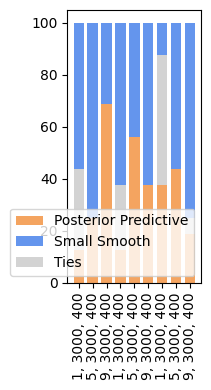

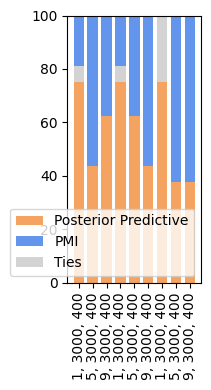

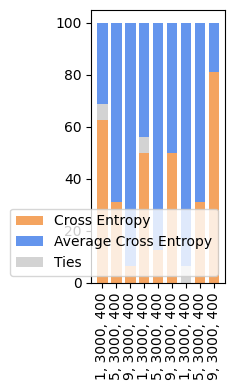

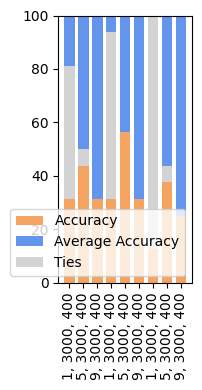

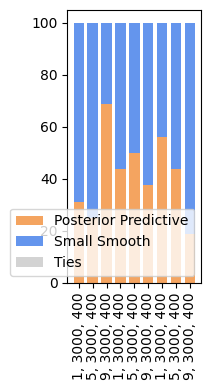

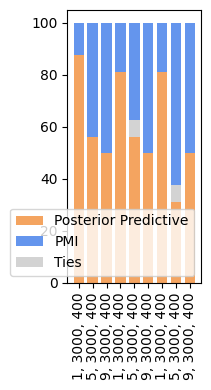

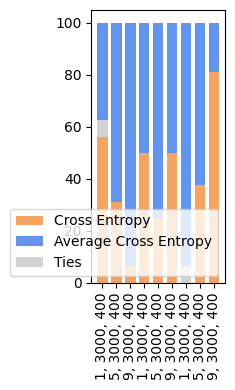

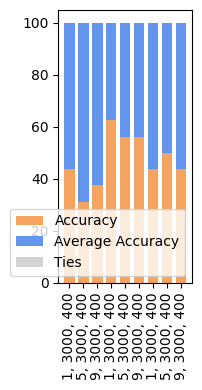

In [12]:
# from pyinstrument import Profiler

# profiler = Profiler()
# profiler.start()
x_label_all = []

single_smooth_post_L_all = []
single_smooth_post_H_all = []
single_score_post_L_all = []
single_score_post_H_all = []
single_post_base_loss_L_all = []
single_post_base_loss_H_all = []
single_post_base_acc_L_all = []
single_post_base_acc_H_all = []

smooth_post_L_all = []
smooth_post_H_all = []
score_post_L_all = []
score_post_H_all = []
post_base_loss_L_all = []
post_base_loss_H_all = []
post_base_acc_L_all = []
post_base_acc_H_all = []

single_acc_all_all = []
acc_all_all = []
single_loss_all_all = []
loss_all_all = []
noise_ratio_all_all = []
label_mae_all_all = []
bias_mae_all_all = []

for test_size in test_size_num:
    x_label = []

    single_smooth_post_L = []
    single_smooth_post_H = []
    single_score_post_L = []
    single_score_post_H = []
    single_post_base_loss_L = []
    single_post_base_loss_H = []
    single_post_base_acc_L = []
    single_post_base_acc_H = []

    smooth_post_L = []
    smooth_post_H = []
    score_post_L = []
    score_post_H = []
    post_base_loss_L = []
    post_base_loss_H = []
    post_base_acc_L = []
    post_base_acc_H = []

    single_acc_all = []
    acc_all = []
    single_loss_all = []
    loss_all = []
    noise_ratio_all = []
    label_mae_all = []
    bias_mae_all = []

    # for num_candidate in range(candidate_L, candidate_H+1, candidate_step):
    for train_size in train_size_num:
        single_total_summary = []
        total_summary = []
        total_noise_ratio = []
        total_label_mae = []
        total_bias_mae = []
        for i in range(len(top_candidate)):
            single_total_summary.append(summary([0,0], [0,0], [0,0], [0,0], result(0,0,0,0,0,0,0,0,0,0,0,0)))
            total_summary.append(summary([0,0], [0,0], [0,0], [0,0], result(0,0,0,0,0,0,0,0,0,0,0,0)))
            total_noise_ratio.append(np.zeros(6))
            total_label_mae.append(np.zeros(6))
            total_bias_mae.append(np.zeros(6))
        for d in tqdm(range(D)):
            test_X = P_x
            test_y = P_y
            # test = LogisticRegression(fit_intercept = False, C = penalty, max_iter=50000).fit(test_X.cpu(), test_y.cpu())
            # acc = test.score(test_X.cpu(), test_y.cpu())
            # print(acc)
            # sys.exit()
            num_candidate = candidate_num
            train_data = generate_train_cifar10(train_size, num_candidate)
            single_total_results = []
            total_results = []
            single_results = []
            results = []
            for i in range(len(top_candidate)):
                single_total_results.append(result(0,0,0,0,0,0,0,0,0,0,0,0))
                total_results.append(result(0,0,0,0,0,0,0,0,0,0,0,0))
                single_results.append([])
                results.append([])
            for t in range(T):
                not_found = True
                while not_found:
                    sample_test_X, sample_test_y = subsample(test_X, test_y, test_size)
                    if torch.sum(sample_test_y)>0 and torch.sum(sample_test_y)<test_size:
                        not_found = False
                
                get_err_score(train_data, sample_test_X, sample_test_y, num_candidate)
                sorted_score = sorted(train_data, key=lambda x: x.score, reverse = True)
                sorted_post_loss = sorted(train_data, key=lambda x: x.post_loss, reverse = False)
                sorted_base_loss = sorted(train_data, key=lambda x: x.base_loss, reverse = False)
                sorted_smooth = sorted(train_data, key=lambda x: x.smooth, reverse = False)
                sorted_post_acc = sorted(train_data, key=lambda x: x.post_acc, reverse = True)
                sorted_base_acc = sorted(train_data, key=lambda x: x.base_acc, reverse = True)

                for i in range(len(top_candidate)):
                    for j in range(top_candidate[i]):
                        total_noise_ratio[i] += np.array([sorted_score[j].noise_ratio, sorted_post_loss[j].noise_ratio, sorted_base_loss[j].noise_ratio, sorted_smooth[j].noise_ratio, sorted_post_acc[j].noise_ratio, sorted_base_acc[j].noise_ratio])
                        total_label_mae[i] += np.array([sorted_score[j].label_mae, sorted_post_loss[j].label_mae, sorted_base_loss[j].label_mae, sorted_smooth[j].label_mae, sorted_post_acc[j].label_mae, sorted_base_acc[j].label_mae])
                        total_bias_mae[i] += np.array([sorted_score[j].bias_mae, sorted_post_loss[j].bias_mae, sorted_base_loss[j].bias_mae, sorted_smooth[j].bias_mae, sorted_post_acc[j].bias_mae, sorted_base_acc[j].bias_mae])

                score_X = sorted_score[0].X
                score_y = sorted_score[0].y
                post_loss_X = sorted_post_loss[0].X
                post_loss_y = sorted_post_loss[0].y
                base_loss_X = sorted_base_loss[0].X
                base_loss_y = sorted_base_loss[0].y
                smooth_X = sorted_smooth[0].X
                smooth_y = sorted_smooth[0].y
                post_acc_X = sorted_post_acc[0].X
                post_acc_y = sorted_post_acc[0].y
                base_acc_X = sorted_base_acc[0].X
                base_acc_y = sorted_base_acc[0].y

                for j in range(1, top_candidate[-1]):
                    score_X = torch.concatenate((score_X, sorted_score[j].X), axis = 0)
                    score_y = torch.concatenate((score_y, sorted_score[j].y), axis = 0)
                    post_loss_X = torch.concatenate((post_loss_X, sorted_post_loss[j].X), axis = 0)
                    post_loss_y = torch.concatenate((post_loss_y, sorted_post_loss[j].y), axis = 0)
                    base_loss_X = torch.concatenate((base_loss_X, sorted_base_loss[j].X), axis = 0)
                    base_loss_y = torch.concatenate((base_loss_y, sorted_base_loss[j].y), axis = 0)
                    smooth_X = torch.concatenate((smooth_X, sorted_smooth[j].X), axis = 0)
                    smooth_y = torch.concatenate((smooth_y, sorted_smooth[j].y), axis = 0)
                    post_acc_X = torch.concatenate((post_acc_X, sorted_post_acc[j].X), axis = 0)
                    post_acc_y = torch.concatenate((post_acc_y, sorted_post_acc[j].y), axis = 0)
                    base_acc_X = torch.concatenate((base_acc_X, sorted_base_acc[j].X), axis = 0)
                    base_acc_y = torch.concatenate((base_acc_y, sorted_base_acc[j].y), axis = 0)

                for i in range(len(top_candidate)):
                    single_score_loss, single_score_acc, score_loss, score_acc = compute_data_err_acc(test_X, test_y, score_X[:int(top_candidate[i]*train_size)], score_y[:int(top_candidate[i]*train_size)])
                    single_post_loss_loss, single_post_loss_acc, post_loss_loss, post_loss_acc = compute_data_err_acc(test_X, test_y, post_loss_X[:int(top_candidate[i]*train_size)], post_loss_y[:int(top_candidate[i]*train_size)])
                    single_base_loss_loss, single_base_loss_acc, base_loss_loss, base_loss_acc = compute_data_err_acc(test_X, test_y, base_loss_X[:int(top_candidate[i]*train_size)], base_loss_y[:int(top_candidate[i]*train_size)])
                    single_smooth_loss, single_smooth_acc, smooth_loss, smooth_acc = compute_data_err_acc(test_X, test_y, smooth_X[:int(top_candidate[i]*train_size)], smooth_y[:int(top_candidate[i]*train_size)])
                    single_post_acc_loss, single_post_acc_acc, post_acc_loss, post_acc_acc = compute_data_err_acc(test_X, test_y, post_acc_X[:int(top_candidate[i]*train_size)], post_acc_y[:int(top_candidate[i]*train_size)])
                    single_base_acc_loss, single_base_acc_acc, base_acc_loss, base_acc_acc = compute_data_err_acc(test_X, test_y, base_acc_X[:int(top_candidate[i]*train_size)], base_acc_y[:int(top_candidate[i]*train_size)])

                    single_resi = result(single_score_loss, single_score_acc, single_post_loss_loss, single_post_loss_acc, single_base_loss_loss, single_base_loss_acc, single_smooth_loss, single_smooth_acc, single_post_acc_loss, single_post_acc_acc, single_base_acc_loss, single_base_acc_acc)
                    resi = result(score_loss, score_acc, post_loss_loss, post_loss_acc, base_loss_loss, base_loss_acc, smooth_loss, smooth_acc, post_acc_loss, post_acc_acc, base_acc_loss, base_acc_acc)
                    single_results[i].append(single_resi)
                    results[i].append(resi)
                    single_total_results[i].add(single_resi)
                    total_results[i].add(resi)

                    # print(single_resi.getacc(), single_resi.getloss(), resi.getacc(), resi.getloss())
                    # sys.exit()
            for i in range(len(top_candidate)):
                single_total_results[i].divide(T)
                total_results[i].divide(T)
                single_summ = summary([0, 0], [0, 0], [0, 0], [0, 0], single_total_results[i])
                summ = summary([0, 0], [0, 0], [0, 0], [0, 0], total_results[i])

                for t in range(T):
                    if single_results[i][t].smooth_acc >= single_results[i][t].post_loss_acc:
                        single_summ.percentage_smooth_post[1] += 1/T*100
                    if single_results[i][t].smooth_acc > single_results[i][t].post_loss_acc:
                        single_summ.percentage_smooth_post[0] += 1/T*100
                    if single_results[i][t].score_acc >= single_results[i][t].post_loss_acc:
                        single_summ.percentage_score_post[1] += 1/T*100
                    if single_results[i][t].score_acc > single_results[i][t].post_loss_acc:
                        single_summ.percentage_score_post[0] += 1/T*100
                    if single_results[i][t].post_loss_acc >= single_results[i][t].base_loss_acc:
                        single_summ.percentage_post_base_loss[1] += 1/T*100
                    if single_results[i][t].post_loss_acc > single_results[i][t].base_loss_acc:
                        single_summ.percentage_post_base_loss[0] += 1/T*100
                    if single_results[i][t].post_acc_acc >= single_results[i][t].base_acc_acc:
                        single_summ.percentage_post_base_acc[1] += 1/T*100
                    if single_results[i][t].post_acc_acc > single_results[i][t].base_acc_acc:
                        single_summ.percentage_post_base_acc[0] += 1/T*100

                    if results[i][t].smooth_acc >= results[i][t].post_loss_acc:
                        summ.percentage_smooth_post[1] += 1/T*100
                    if results[i][t].smooth_acc > results[i][t].post_loss_acc:
                        summ.percentage_smooth_post[0] += 1/T*100
                    if results[i][t].score_acc >= results[i][t].post_loss_acc:
                        summ.percentage_score_post[1] += 1/T*100
                    if results[i][t].score_acc > results[i][t].post_loss_acc:
                        summ.percentage_score_post[0] += 1/T*100
                    if results[i][t].post_loss_acc >= results[i][t].base_loss_acc:
                        summ.percentage_post_base_loss[1] += 1/T*100
                    if results[i][t].post_loss_acc > results[i][t].base_loss_acc:
                        summ.percentage_post_base_loss[0] += 1/T*100
                    if results[i][t].post_acc_acc >= results[i][t].base_acc_acc:
                        summ.percentage_post_base_acc[1] += 1/T*100
                    if results[i][t].post_acc_acc > results[i][t].base_acc_acc:
                        summ.percentage_post_base_acc[0] += 1/T*100
                single_total_summary[i].add(single_summ)
                total_summary[i].add(summ)
        for i in range(len(top_candidate)):
            single_total_summary[i].divide(D)
            total_summary[i].divide(D)
            total_noise_ratio[i] = total_noise_ratio[i] / (T*D*top_candidate[i])
            total_label_mae[i] = total_label_mae[i] / (T*D*top_candidate[i])
            total_bias_mae[i] = total_bias_mae[i] / (T*D*top_candidate[i])
            label = str(top_candidate[i]) + ", " + str(test_size) + ", " + str(num_candidate)
            x_label.append(label)
            single_acc = single_total_summary[i].getacc()
            acc = total_summary[i].getacc()
            single_loss = single_total_summary[i].getloss()
            loss = total_summary[i].getloss()
            print("Acc " + "& $"+label+"$ & " + "{:.4f}".format(single_acc[0]) + " & " + "{:.4f}".format(single_acc[1]) + " & " + "{:.4f}".format(single_acc[2]) + " & " + "{:.4f}".format(single_acc[3]) + " & " + "{:.4f}".format(single_acc[4]) + " & " + "{:.4f}".format(single_acc[5]) +" \\\\ " )
            print("Aver. Acc " + "& $"+label+"$ & " + "{:.4f}".format(acc[0]) + " & " + "{:.4f}".format(acc[1]) + " & " + "{:.4f}".format(acc[2]) + " & " + "{:.4f}".format(acc[3]) + " & " + "{:.4f}".format(acc[4]) + " & " + "{:.4f}".format(acc[5]) +" \\\\ " )
            # print("$"+label+"$ & " + "{:.4f}".format(single_acc[0]-acc[0]) + " & " + "{:.4f}".format(single_acc[1]-acc[1]) + " & " + "{:.4f}".format(single_acc[2]-acc[2]) + " & " + "{:.4f}".format(single_acc[3]-acc[3]) + " & " + "{:.4f}".format(single_acc[4]-acc[4]) + " & " + "{:.4f}".format(single_acc[5]-acc[5]) + " \\\\ " )
            print("Loss " + "& $"+label+"$ & " + "{:.4f}".format(single_loss[0]) + " & " + "{:.4f}".format(single_loss[1]) + " & " + "{:.4f}".format(single_loss[2]) + " & " + "{:.4f}".format(single_loss[3]) + " & " + "{:.4f}".format(single_loss[4]) + " & " + "{:.4f}".format(single_loss[5]) +" \\\\ " )
            print("Aver. Loss " + "& $"+label+"$ & " + "{:.4f}".format(loss[0]) + " & " + "{:.4f}".format(loss[1]) + " & " + "{:.4f}".format(loss[2]) + " & " + "{:.4f}".format(loss[3]) + " & " + "{:.4f}".format(loss[4]) + " & " + "{:.4f}".format(loss[5]) +" \\\\ " )
            print("Noise Ratio " + "& $" + label + "$ & " + "{:.4f}".format(total_noise_ratio[i][0]) + " & " + "{:.4f}".format(total_noise_ratio[i][1]) + " & " + "{:.4f}".format(total_noise_ratio[i][2]) + " & " + "{:.4f}".format(total_noise_ratio[i][3]) + " & " + "{:.4f}".format(total_noise_ratio[i][4]) + " & " + "{:.4f}".format(total_noise_ratio[i][5]) +" \\\\ " )
            print("Label MAE " + "& $" + label + "$ & " + "{:.4f}".format(total_label_mae[i][0]) + " & " + "{:.4f}".format(total_label_mae[i][1]) + " & " + "{:.4f}".format(total_label_mae[i][2]) + " & " + "{:.4f}".format(total_label_mae[i][3]) + " & " + "{:.4f}".format(total_label_mae[i][4]) + " & " + "{:.4f}".format(total_label_mae[i][5]) +" \\\\ " + " \\hline")
            print("Bias MAE " + "& $" + label + "$ & " + "{:.4f}".format(total_bias_mae[i][0]) + " & " + "{:.4f}".format(total_bias_mae[i][1]) + " & " + "{:.4f}".format(total_bias_mae[i][2]) + " & " + "{:.4f}".format(total_bias_mae[i][3]) + " & " + "{:.4f}".format(total_bias_mae[i][4]) + " & " + "{:.4f}".format(total_bias_mae[i][5]) +" \\\\ " + " \\hline")
            # print("$"+label+"$ & " + "{:.4f}".format(single_loss[0]-loss[0]) + " & " + "{:.4f}".format(single_loss[1]-loss[1]) + " & " + "{:.4f}".format(single_loss[2]-loss[2]) + " & " + "{:.4f}".format(single_loss[3]-loss[3]) + " & " + "{:.4f}".format(single_loss[4]-loss[4]) + " & " + "{:.4f}".format(single_loss[5]-loss[5]) + " \\\\ " )
            single_smooth_post_L.append(single_total_summary[i].percentage_smooth_post[0])
            single_smooth_post_H.append(single_total_summary[i].percentage_smooth_post[1])
            single_score_post_L.append(single_total_summary[i].percentage_score_post[0])
            single_score_post_H.append(single_total_summary[i].percentage_score_post[1])
            single_post_base_loss_L.append(single_total_summary[i].percentage_post_base_loss[0])
            single_post_base_loss_H.append(single_total_summary[i].percentage_post_base_loss[1])
            single_post_base_acc_L.append(single_total_summary[i].percentage_post_base_acc[0])
            single_post_base_acc_H.append(single_total_summary[i].percentage_post_base_acc[1])

            smooth_post_L.append(total_summary[i].percentage_smooth_post[0])
            smooth_post_H.append(total_summary[i].percentage_smooth_post[1])
            score_post_L.append(total_summary[i].percentage_score_post[0])
            score_post_H.append(total_summary[i].percentage_score_post[1])
            post_base_loss_L.append(total_summary[i].percentage_post_base_loss[0])
            post_base_loss_H.append(total_summary[i].percentage_post_base_loss[1])
            post_base_acc_L.append(total_summary[i].percentage_post_base_acc[0])
            post_base_acc_H.append(total_summary[i].percentage_post_base_acc[1])

            single_acc_all.append(single_acc)
            acc_all.append(acc)
            single_loss_all.append(single_loss)
            loss_all.append(loss)
            noise_ratio_all.append(total_noise_ratio[i])
            label_mae_all.append(total_label_mae[i])
            bias_mae_all.append(total_bias_mae[i])
        # profiler.stop()

        # profiler.print()
        # sys.exit()
    
    x_label_all += x_label
    single_smooth_post_L_all += single_smooth_post_L
    single_smooth_post_H_all += single_smooth_post_H
    single_score_post_L_all += single_score_post_L
    single_score_post_H_all += single_score_post_H
    single_post_base_loss_L_all += single_post_base_loss_L
    single_post_base_loss_H_all += single_post_base_loss_H
    single_post_base_acc_L_all += single_post_base_acc_L
    single_post_base_acc_H_all += single_post_base_acc_H

    smooth_post_L_all += smooth_post_L
    smooth_post_H_all += smooth_post_H
    score_post_L_all += score_post_L
    score_post_H_all += score_post_H
    post_base_loss_L_all += post_base_loss_L
    post_base_loss_H_all += post_base_loss_H
    post_base_acc_L_all += post_base_acc_L
    post_base_acc_H_all += post_base_acc_H

    single_acc_all_all += single_acc_all
    acc_all_all += acc_all
    single_loss_all_all += single_loss_all
    loss_all_all += loss_all
    noise_ratio_all_all += noise_ratio_all
    label_mae_all_all += label_mae_all
    bias_mae_all_all += bias_mae_all

    generate_plot(x_label, single_smooth_post_L, single_smooth_post_H, 'Posterior Predictive', 'Small Smooth', 'single_smooth_post')
    generate_plot(x_label, single_score_post_L, single_score_post_H, 'Posterior Predictive', 'PMI', 'single_score_post')
    generate_plot(x_label, single_post_base_loss_L, single_post_base_loss_H, 'Cross Entropy', 'Average Cross Entropy', 'single_post_base_loss')
    generate_plot(x_label, single_post_base_acc_L, single_post_base_acc_H, 'Accuracy', 'Average Accuracy', 'single_post_base_acc')
    generate_plot(x_label, smooth_post_L, smooth_post_H, 'Posterior Predictive', 'Small Smooth', 'smooth_post')
    generate_plot(x_label, score_post_L, score_post_H, 'Posterior Predictive', 'PMI', 'score_post')
    generate_plot(x_label, post_base_loss_L, post_base_loss_H, 'Cross Entropy', 'Average Cross Entropy', 'post_base_loss')
    generate_plot(x_label, post_base_acc_L, post_base_acc_H, 'Accuracy', 'Average Accuracy', 'post_base_acc')

# profiler.stop()

# profiler.print()


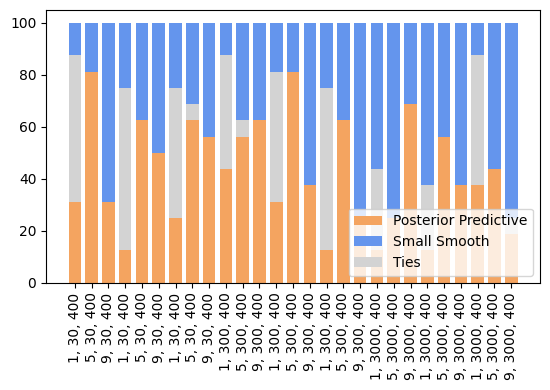

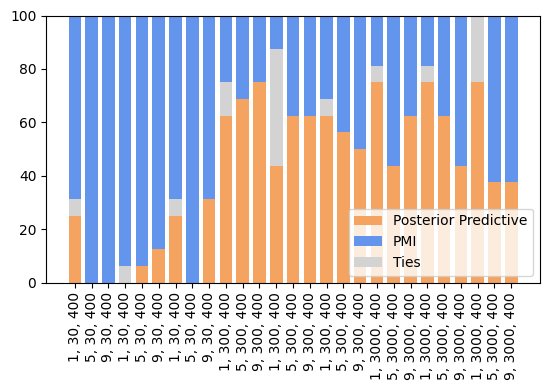

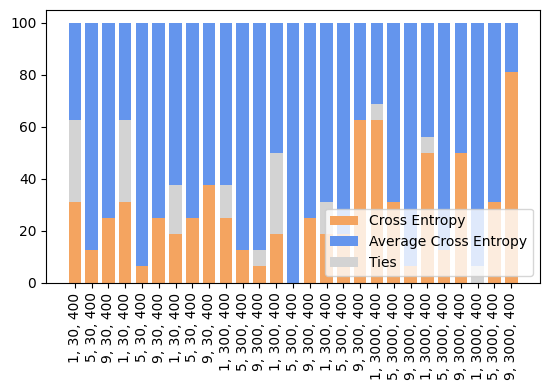

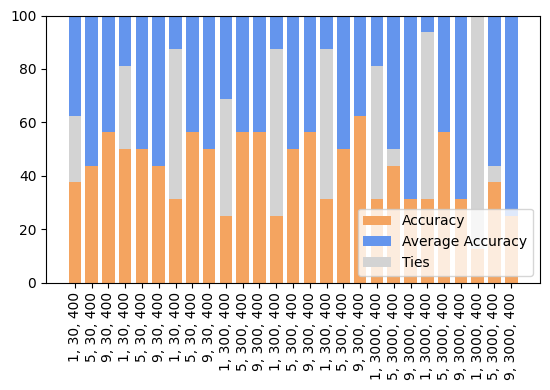

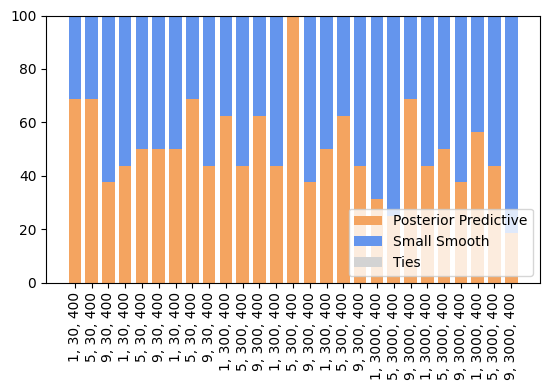

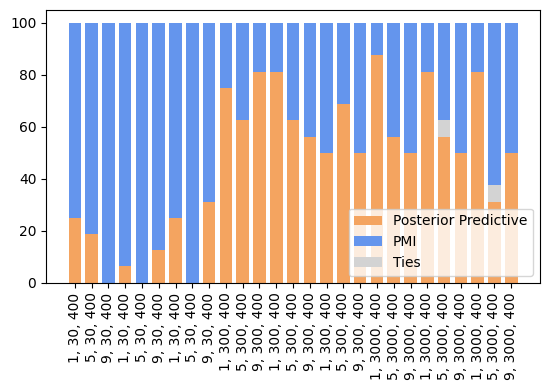

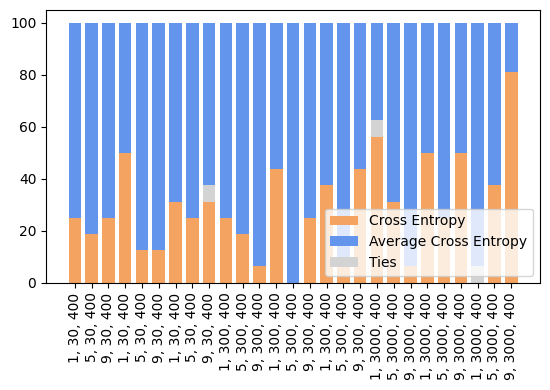

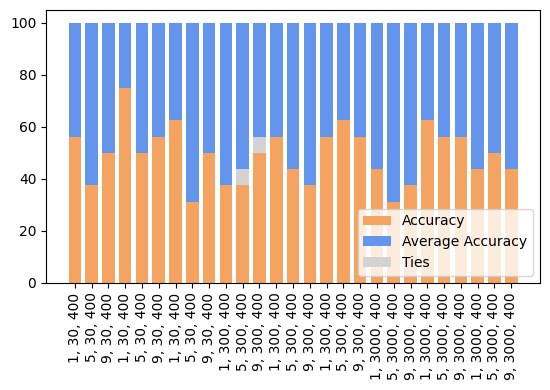

In [13]:
generate_plot(x_label_all, single_smooth_post_L_all, single_smooth_post_H_all, 'Posterior Predictive', 'Small Smooth', 'single_smooth_post_all')
generate_plot(x_label_all, single_score_post_L_all, single_score_post_H_all, 'Posterior Predictive', 'PMI', 'single_score_post_all')
generate_plot(x_label_all, single_post_base_loss_L_all, single_post_base_loss_H_all, 'Cross Entropy', 'Average Cross Entropy', 'single_post_base_loss_all')
generate_plot(x_label_all, single_post_base_acc_L_all, single_post_base_acc_H_all, 'Accuracy', 'Average Accuracy', 'single_post_base_acc_all')
generate_plot(x_label_all, smooth_post_L_all, smooth_post_H_all, 'Posterior Predictive', 'Small Smooth', 'smooth_post_all')
generate_plot(x_label_all, score_post_L_all, score_post_H_all, 'Posterior Predictive', 'PMI', 'score_post_all')
generate_plot(x_label_all, post_base_loss_L_all, post_base_loss_H_all, 'Cross Entropy', 'Average Cross Entropy', 'post_base_loss_all')
generate_plot(x_label_all, post_base_acc_L_all, post_base_acc_H_all, 'Accuracy', 'Average Accuracy', 'post_base_acc_all')

In [14]:
# print(acc_all_all)
# print(single_total_summary[2].total_result.score_loss)
# print(single_total_summary[2].total_result.score_acc)
# print(single_total_summary[2].total_result.err_loss)
# print(single_total_summary[2].total_result.err_acc)
# print(single_total_summary[2].total_result.post_loss)
# print(single_total_summary[2].total_result.post_acc)
# print(single_total_summary[2].total_result.acc_loss)
# print(single_total_summary[2].total_result.acc_acc)
# print(single_total_summary[2].total_result.smooth_loss)
# print(single_total_summary[2].total_result.smooth_acc)

In [15]:
def generate_detail_plot(x_label, loss, label):
#    print(width, gap)
    score_loss = []
    post_loss_loss = []
    base_loss_loss = []
    small_smooth_loss = []
    post_acc_loss = []
    base_acc_loss = []
    for i in range(27):
        score_loss.append(loss[i][0])
        post_loss_loss.append(loss[i][1])
        base_loss_loss.append(loss[i][2])
        small_smooth_loss.append(loss[i][3])
        post_acc_loss.append(loss[i][4])
        base_acc_loss.append(loss[i][5])
    x = np.array(range(len(x_label))) * (width*7 + gap*2)
#    print(e_L, e_H)
    
    plt.rcParams['figure.figsize'] = [(width*7 + gap*2) * (len(x_label) + 1), 4]
    plt.bar(x-2.5*width, score_loss, width = width, label = "PMI")
    plt.bar(x-1.5*width, post_loss_loss, width = width, label = "Average Cross Entropy")
    plt.bar(x-0.5*width, base_loss_loss, width = width, label = "Cross Entropy")
    plt.bar(x+0.5*width, small_smooth_loss, width = width, label = "Small Smooth")
    plt.bar(x+1.5*width, post_acc_loss, width = width, label = "Average Accuracy")
    plt.bar(x+2.5*width, base_acc_loss, width = width, label = "Accuracy")
    plt.xticks(x, x_label, rotation='vertical')
    plt.tight_layout()
    plt.legend(loc=4)
    plt.savefig("figure/imdb/"+label+".pdf", format="pdf", dpi=20) #add legend
    plt.show()

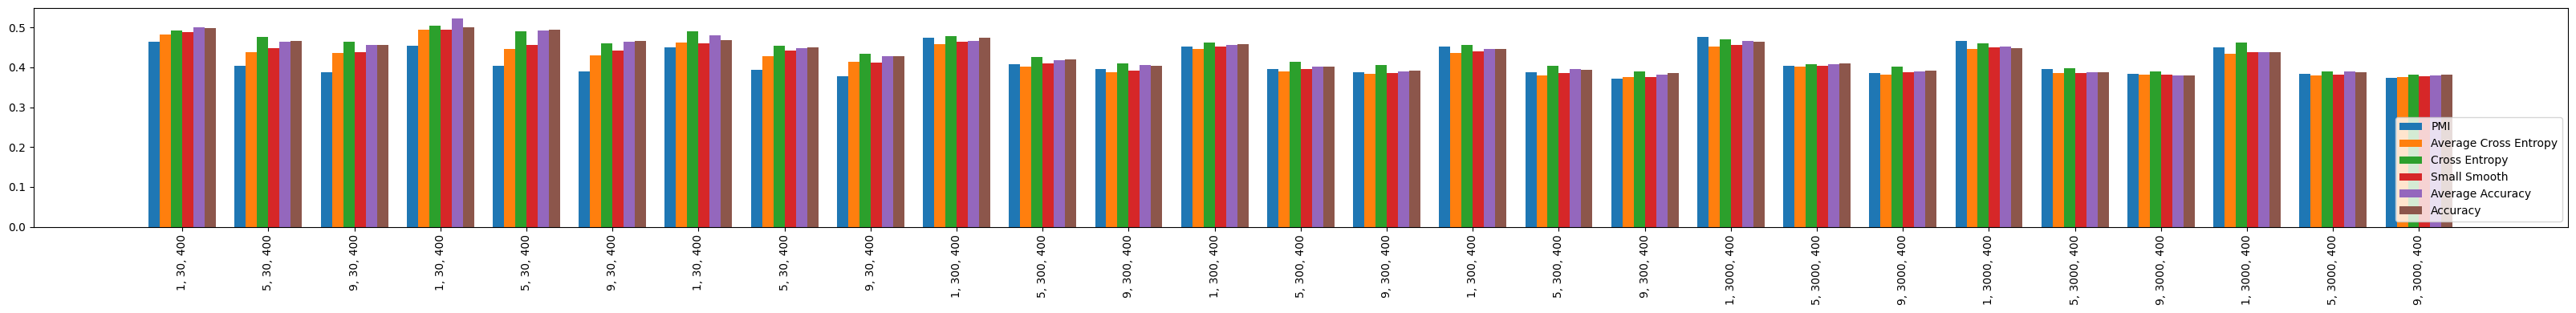

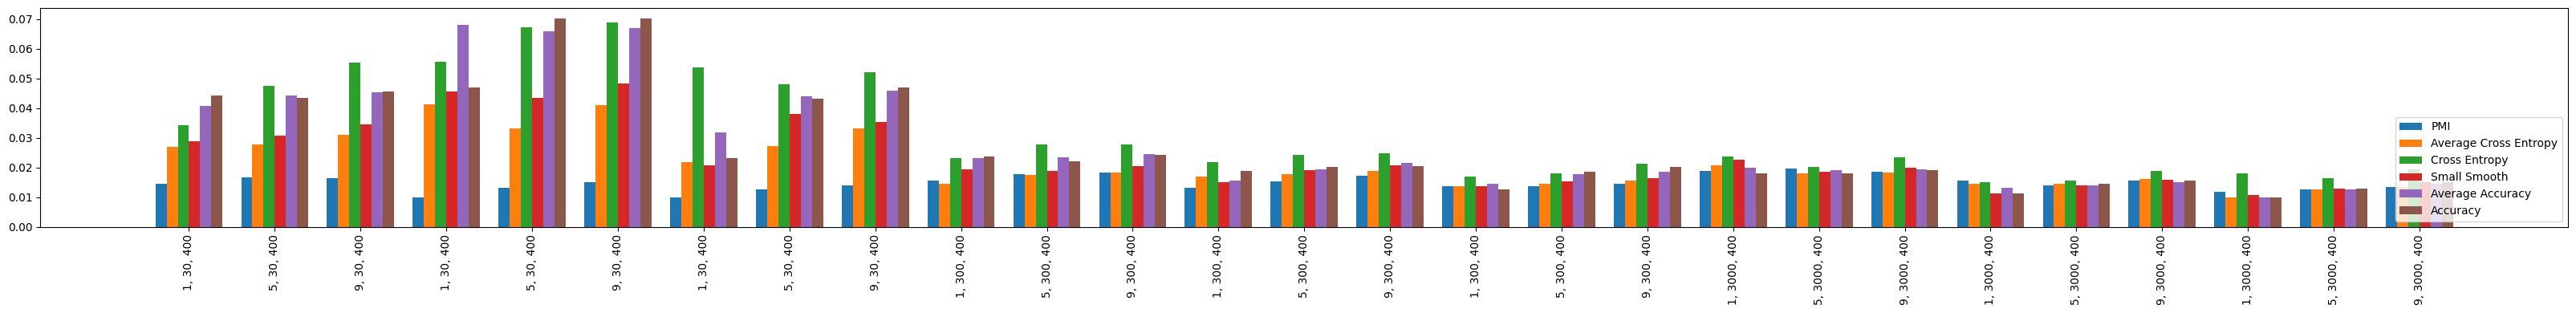

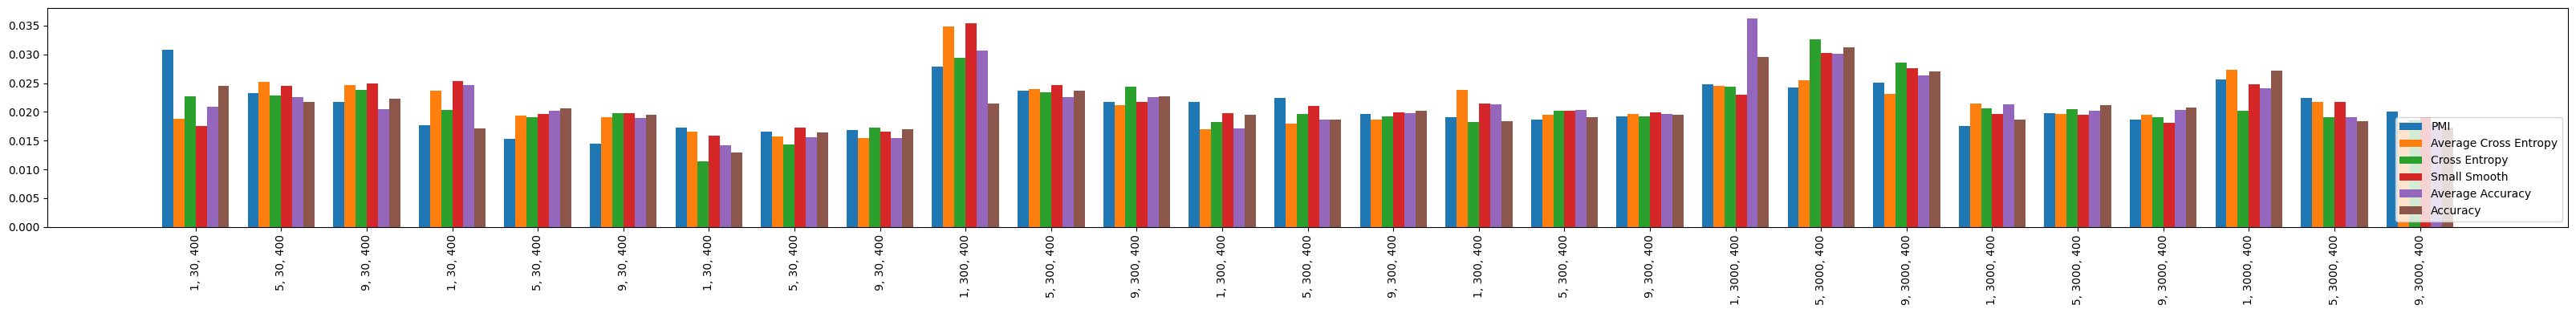

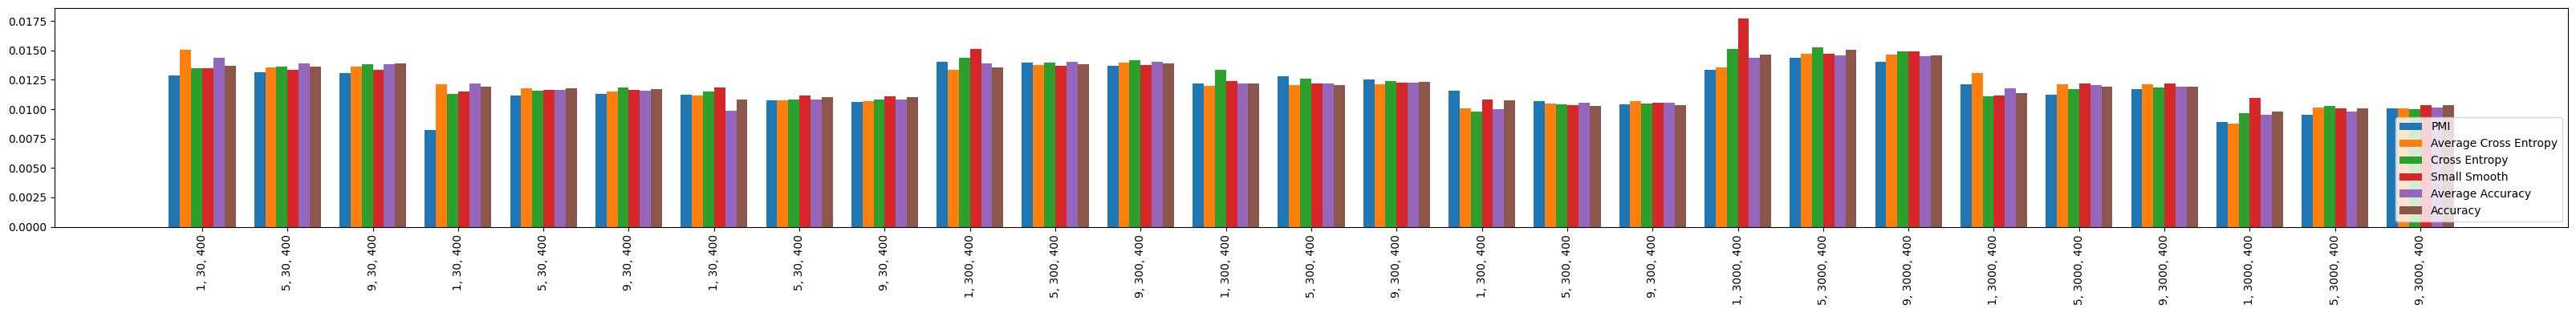

In [16]:
generate_detail_plot(x_label_all, loss_all_all, "loss")
generate_detail_plot(x_label_all, noise_ratio_all_all, "noise_ratio")
generate_detail_plot(x_label_all, label_mae_all_all, "label_mae")
generate_detail_plot(x_label_all, bias_mae_all_all, "bias_mae")

In [17]:
# profiler.stop()

# profiler.print()